# **Install & Import Required Libraries**

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# **Load Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET_PATH = "/content/drive/MyDrive/flower"
os.listdir(DATASET_PATH)

['Sunflower', 'Rose', 'Hibiscus']

In [5]:
IMG_SIZE = 128

images = []
labels = []
class_names = sorted(os.listdir(DATASET_PATH))

for label, class_name in enumerate(class_names):
    class_path = os.path.join(DATASET_PATH, class_name)

    for img_name in os.listdir(class_path):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue  # skip non-image files

        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print("Skipped unreadable image:", img_path)
            continue  # skip unreadable files

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

# **Dataset Evaluation**

In [6]:
# Count images per class
class_counts = [np.sum(labels == i) for i in range(len(class_names))]
total_images = sum(class_counts)
class_percentages = [count / total_images * 100 for count in class_counts]

# --- Print dataset summary ---
print("Dataset Summary:\n")
print(f"{'Class':15} {'Count':>8} {'Percentage':>12}")
print("-"*37)
for name, count, perc in zip(class_names, class_counts, class_percentages):
    print(f"{name:15} {count:8} {perc:11.2f}%")
print("-"*37)
print(f"{'Total':15} {total_images:8} {100:11.2f}%")

Dataset Summary:

Class              Count   Percentage
-------------------------------------
Hibiscus             212       45.30%
Rose                 109       23.29%
Sunflower            147       31.41%
-------------------------------------
Total                468      100.00%


/tmp/ipython-input-1793385732.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts, palette="pastel")


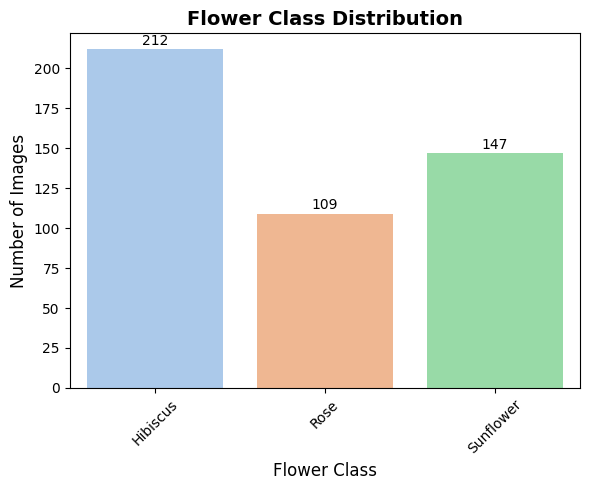

In [7]:
import seaborn as sns

# Count images per class
class_counts = [np.sum(labels == i) for i in range(len(class_names))]

# Plot
plt.figure(figsize=(6,5))
sns.barplot(x=class_names, y=class_counts, palette="pastel")
plt.title("Flower Class Distribution", fontsize=14, weight="bold")
plt.ylabel("Number of Images", fontsize=12)
plt.xlabel("Flower Class", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 10)

# Add value labels on top of bars
for i, count in enumerate(class_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# **Feature Extraction**

**HOG Features**

In [8]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )
        hog_features.append(features)
    return np.array(hog_features)
print(extract_hog_features(images).shape)

(468, 8100)


**Color Features**

In [9]:
def extract_color_features(images, bins=32):
    color_features = []
    for img in images:
        rgb_hist = []
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        for i in range(3):
            rgb_hist.extend(
                cv2.calcHist([img], [i], None, [bins], [0, 256]).flatten()
            )
            rgb_hist.extend(
                cv2.calcHist([hsv], [i], None, [bins], [0, 256]).flatten()
            )

        color_features.append(rgb_hist)

    return np.array(color_features)
print(extract_color_features(images, bins=32).shape)

(468, 192)


**Combine Features**

In [10]:
hog_features = extract_hog_features(images)
color_features = extract_color_features(images)

X_features = np.hstack((hog_features, color_features))
print(X_features.shape)

(468, 8292)


# **Train-Test Split + Scalling of Extracted Features**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_features, labels, test_size=0.2, stratify=labels, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# **Models**

**Random Forest Model**

In [12]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("\n",classification_report(y_test, rf_preds))


Random Forest Accuracy: 0.9361702127659575

               precision    recall  f1-score   support

           0       0.91      0.95      0.93        43
           1       0.95      0.95      0.95        22
           2       0.96      0.90      0.93        29

    accuracy                           0.94        94
   macro avg       0.94      0.93      0.94        94
weighted avg       0.94      0.94      0.94        94



**SVM Model**

In [13]:
svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale'
)

svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_preds))
print("\n",classification_report(y_test, svm_preds))


SVM Accuracy: 0.9042553191489362

               precision    recall  f1-score   support

           0       0.83      1.00      0.91        43
           1       1.00      0.77      0.87        22
           2       1.00      0.86      0.93        29

    accuracy                           0.90        94
   macro avg       0.94      0.88      0.90        94
weighted avg       0.92      0.90      0.90        94



**CNN Model**

***Initial CNN Model***

*The initial CNN was trained from scratch on a small image dataset. Since CNNs require large amounts of data to learn effective visual features, the limited dataset led to poor generalization and higher misclassification, especially between visually similar classes. Consequently, the CNN underperformed compared to traditional models such as Random Forest and Support Vector Machine, which are better suited for smaller datasets.*

In [14]:
X_img = images / 255.0

X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_img, labels, test_size=0.2, stratify=labels, random_state=42
)
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
cnn_model.fit(
    X_train_img,
    y_train_img,
    epochs=15,
    batch_size=32,
    validation_split=0.1
)
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_img, y_test_img)
print("CNN Accuracy:", cnn_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - accuracy: 0.4042 - loss: 1.2909 - val_accuracy: 0.6842 - val_loss: 0.8439
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6926 - loss: 0.7730 - val_accuracy: 0.6842 - val_loss: 0.5598
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7499 - loss: 0.5432 - val_accuracy: 0.6842 - val_loss: 0.5348
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8146 - loss: 0.4747 - val_accuracy: 0.8158 - val_loss: 0.4274
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8514 - loss: 0.3866 - val_accuracy: 0.8421 - val_loss: 0.4229
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8577 - loss: 0.3134 - val_accuracy: 0.8421 - val_loss: 0.3122
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8808 - loss: 0.3111 - val_accuracy: 0.8684 - val_loss: 0.2220
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9525 - loss: 0.1569 - val_accuracy: 0.9211 -

***Final Improved CNN Model***

*To overcome the limitations of the initial CNN, transfer learning was implemented using the MobileNetV2 model pretrained on ImageNet. The pretrained network provided robust feature representations, removing the need to learn basic visual patterns from scratch. Data augmentation techniques, including rotation, zooming, shifting, and horizontal flipping, were applied to increase training data diversity and reduce overfitting. As a result, the improved CNN achieved better feature extraction, higher classification accuracy, and improved generalization, with reduced class confusion on unseen test data, demonstrating the effectiveness of pretrained models for small-scale image classification.*

In [22]:
# Normalize images
X_img = images.astype("float32") / 255.0

#Train-test split
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_img,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train_img)

# Transfer learning base model
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze pretrained layers

# Final CNN model
cnn_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    Dense(128, activation="relu"),
    Dropout(0.5),

    Dense(len(class_names), activation="softmax")
])

# compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# train model
history = cnn_model.fit(
    datagen.flow(X_train_img, y_train_img, batch_size=32),
    epochs=30,
    validation_data=(X_test_img, y_test_img)
)

# Evaluate model
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_img, y_test_img)
print("Improved CNN Accuracy:", cnn_acc)

# Predict class labels
cnn_probs = cnn_model.predict(X_test_img)
cnn_preds = np.argmax(cnn_probs, axis=1)

# Classification report
print("\nCNN Classification Report:")
print(classification_report(y_test_img, cnn_preds))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2959 - loss: 1.8951 - val_accuracy: 0.4787 - val_loss: 1.0076
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5865 - loss: 0.9842 - val_accuracy: 0.6170 - val_loss: 0.7659
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6465 - loss: 0.8073 - val_accuracy: 0.8085 - val_loss: 0.5660
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7733 - loss: 0.5901 - val_accuracy: 0.8511 - val_loss: 0.4642
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8498 - loss: 0.4388 - val_accuracy: 0.8723 - val_loss: 0.3834
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8563 - loss: 0.3839 - val_accuracy: 0.8830 - val_loss: 0.3268
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8534 - loss: 0.4000 - val_accuracy: 0.9043 - val_loss: 0.2756
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8855 - loss: 0.2953 - val_accuracy: 0.92

***CNN plot training accuracy and loss***

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


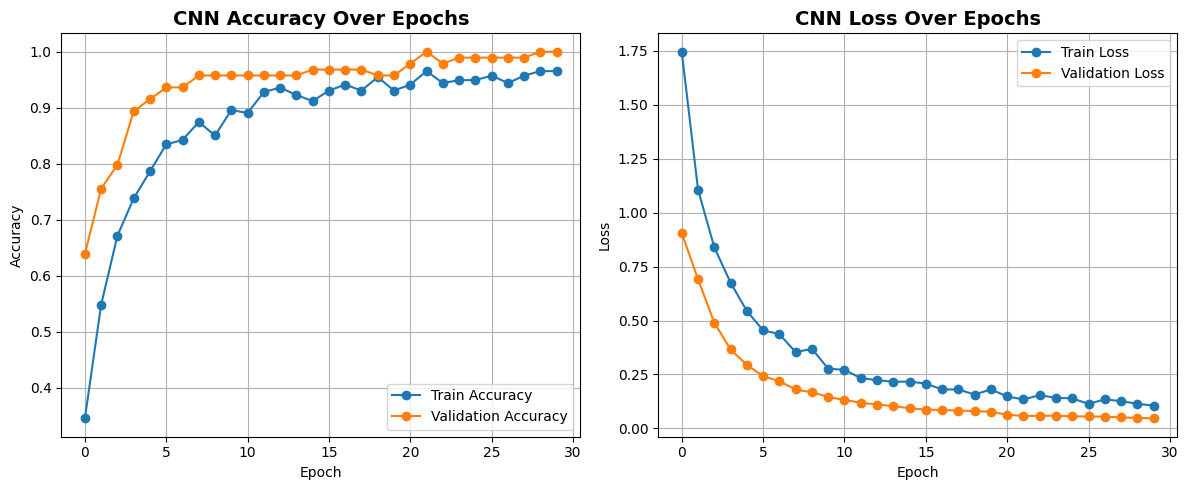

In [16]:
# --- CNN Predictions ---
cnn_preds = np.argmax(cnn_model.predict(X_test_img), axis=1)

# --- Plot Training Accuracy and Loss ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('CNN Accuracy Over Epochs', fontsize=14, weight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('CNN Loss Over Epochs', fontsize=14, weight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **Confusion Matrix (All Models)**

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


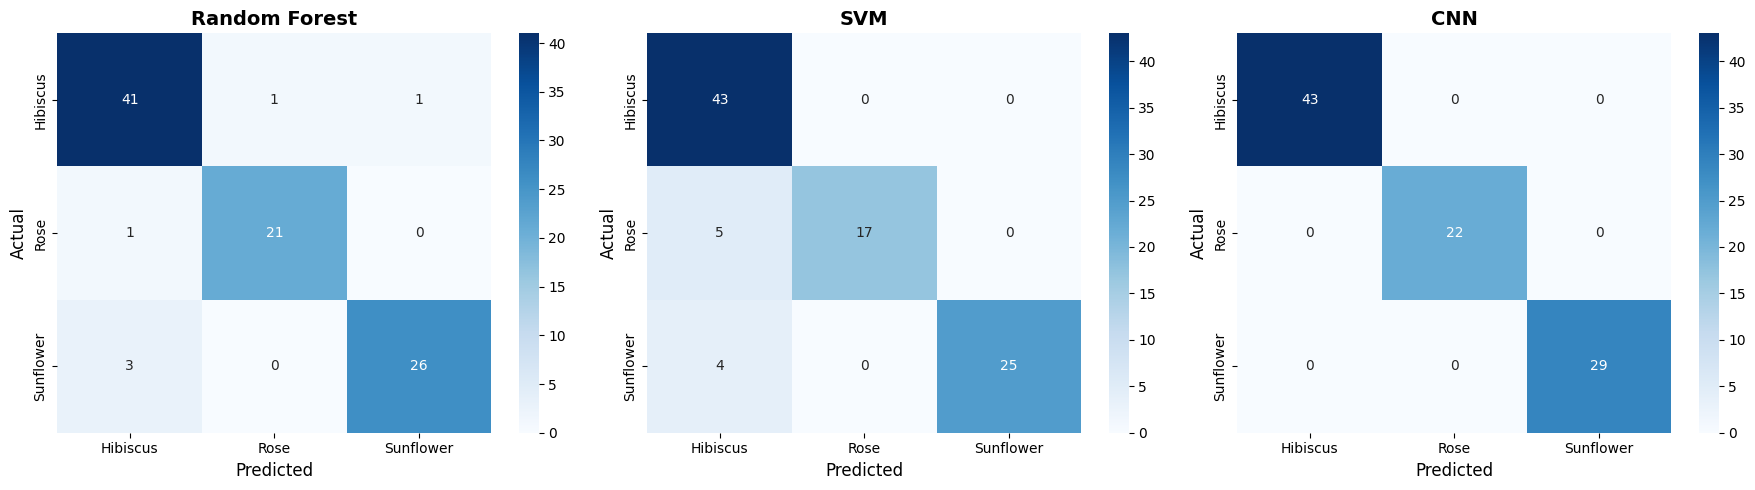

In [17]:
import seaborn as sns

# --- Updated function to include class names ---
def plot_cm(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)

# --- Plot all 3 confusion matrices side by side ---
plt.figure(figsize=(18,5))

# Random Forest
plt.subplot(1, 3, 1)
plot_cm(y_test, rf_preds, "Random Forest", class_names)

# SVM
plt.subplot(1, 3, 2)
plot_cm(y_test, svm_preds, "SVM", class_names)

# CNN
cnn_preds = np.argmax(cnn_model.predict(X_test_img), axis=1)
plt.subplot(1, 3, 3)
plot_cm(y_test_img, cnn_preds, "CNN", class_names)

plt.tight_layout()
plt.show()


# **Final Comparision**

/tmp/ipython-input-3622844088.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


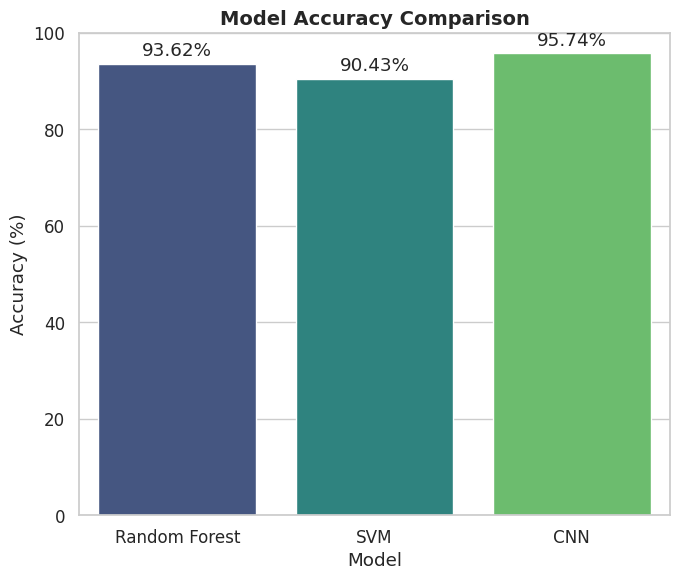

In [20]:
results = {
    "Model": ["Random Forest", "SVM", "CNN"],
    "Accuracy": [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, svm_preds),
        cnn_acc
    ]
}

import pandas as pd

results_df = pd.DataFrame(results)
results_df["Accuracy (%)"] = results_df["Accuracy"] * 100

# Better style
sns.set_theme(style="whitegrid", font_scale=1.1)

# Plot
plt.figure(figsize=(7,6))
ax = sns.barplot(
    data=results_df,
    x="Model",
    y="Accuracy (%)",
    palette="viridis"
)

# Axis settings
plt.ylim(0, 100)
plt.title("Model Accuracy Comparison", fontsize=14, weight="bold")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%", padding=3)

plt.tight_layout()
plt.show()
